# Analysing nutritional information of menu items at different Fast-Food Companies


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

df = pd.read_csv("FastFoodNutritionMenuV2.csv")
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,McDonald’s,Hamburger,250,80,9,3.5,0.5,25,520,31,2,6,12,247.5
1,McDonald’s,Cheeseburger,300,110,12,6,0.5,40,750,33,2,6,15,297
2,McDonald’s,Double Cheeseburger,440,210,23,11,1.5,80,1150,34,2,7,25,433
3,McDonald’s,McDouble,390,170,19,8,1,65,920,33,2,7,22,383
4,McDonald’s,Quarter Pounder® with Cheese,510,230,26,12,1.5,90,1190,40,3,9,29,502


In [3]:
df.shape

(1148, 14)

In [4]:
# Just getting an idea of what companies are involved 
# and what proprtion of the data belongs to each company
(df.groupby("Company")["Item"].count()*100)/df.shape[0]

Company
Burger King    16.550523
KFC            18.989547
McDonald’s     28.658537
Pizza Hut       6.445993
Taco Bell      15.940767
Wendy’s        13.414634
Name: Item, dtype: float64

## Cleaning and Wrangling the data

In [5]:
# remove whitespaces
df.columns  = df.columns.str.strip()

# convert some columns columns to numeric
for column in df.columns:
    if column != "Company" and column != "Item":
        df[column] = pd.to_numeric(df[column], errors="coerce")

In [6]:
# find out the proportion of null values for each column
def show_null_proportion():
    row = []
    for column in df.columns:
        # find proportions for each column
        row.append(df[df.isnull().any(axis=1)][column].isnull().sum()/df.shape[0])

    null_prop_df = pd.DataFrame(columns=df.columns)
    null_prop_df.loc[0] = row
    return null_prop_df

In [7]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,0.0,0.0,0.013066,0.45122,0.060105,0.060976,0.060105,0.025261,0.013937,0.060976,0.073171,0.026132,0.060105,0.236934


The Calories from Fat and Weight WatchersPnts columns seem to have a lot of missing values.
After calculating some Weight Watcher values using online calculators, the values in the table do not seem to be consistent. Therefore it's best to not consider finding Weight WatchersPnts for all entries

Calories from Fat can be calculated by:
Calories from Fat = 9(c/g) * Total Fat(g)

We can confirm that the data, where Total Fat and Calories from Fat do exist, roughly matches this formula

In [8]:
# we should expect when we divide Total Fat * 9 by Calories from Fat we get 1
test_df = df.dropna()
(test_df["Total Fat(g)"]*9 / test_df["Calories from Fat"]).describe()

count    352.000000
mean       1.007104
std        0.075469
min        0.900000
25%        0.990000
50%        1.005882
75%        1.028571
max        1.800000
dtype: float64

### Dealing with missing values
We will fill in the rest of the data in the Calories from Fat column using the formula, when the total fat does exist

In [9]:
def fill_cal_from_fat(r):
    # if "Calories from Fat" is empty and total fat exists
    if pd.isna(r["Calories from Fat"]) and not pd.isna(r["Total Fat(g)"]):
        
        return r["Total Fat(g)"] * 9
    # leave as it is
    return r["Calories from Fat"]

df["Calories from Fat"] = df.apply(fill_cal_from_fat, axis=1)

In [10]:
#check the new proportion
print(df[df.isnull().any(axis=1)]["Calories from Fat"].isnull().sum()/df.shape[0])

0.06010452961672474


Now deleting rows where all values are null (Items that have absolutely no information about them other than item name and company)

In [11]:
# filter enrtries that don't have all of these columns null
df = df[df[["Calories", "Calories from Fat", "Total Fat(g)", "Saturated Fat(g)", "Trans Fat(g)", "Cholesterol(mg)", "Sodium (mg)", "Carbs(g)", "Fiber(g)", "Sugars(g)", "Protein(g)" ]].notna().any(axis=1)]

In [12]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,0.0,0.0,0.0,0.047661,0.047661,0.048544,0.047661,0.012357,0.000883,0.048544,0.0609,0.013239,0.047661,0.226831


In [13]:
companies = df.groupby("Company")["Item"].count().keys()

### Transform the dataframe into seperate dataframes based on company 

In [14]:
# Entry will contain a key being the company name and value being the df for that company
company_dfs = {}
for company in companies:
    company_dfs[company] = df[df["Company"] == company].drop(['Company'], axis=1)

In [15]:
company_dfs["KFC"].head()

,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
673,Limited Time Cinnabon Dessert Biscuits,290.0,117.0,13.0,7.0,0.0,NaN,580.0,40.0,2.0,17.0,4.0,310.0
674,Limited Time ORIGINAL RECIPE CHICKEN Chicken B...,390.0,189.0,21.0,4.0,0.0,120.0,1190.0,11.0,2.0,0.0,39.0,355.0
675,Limited Time ORIGINAL RECIPE CHICKEN Chicken L...,130.0,72.0,8.0,1.5,0.0,55.0,430.0,4.0,1.0,0.0,12.0,119.5
676,Limited Time ORIGINAL RECIPE CHICKEN Chicken T...,280.0,171.0,19.0,4.5,0.0,100.0,910.0,8.0,1.0,0.0,19.0,265.5
677,Limited Time ORIGINAL RECIPE CHICKEN Chicken W...,130.0,72.0,8.0,2.0,0.0,55.0,380.0,3.0,0.0,0.0,10.0,122.0


## Exploring the Data

### Investigating which Fast-Food companies are the most and least healthy

In [ ]:
# function that gets a columns filtered by company
def get_companies_dataseries(column:str):
    info =  []
    for company in companies:
        # some columns are heavily skewed by items with 0 eg. sauce packets, drinks
        # can cause the mean to become 0 
        info.append(df[(df["Company"] == company) & (df[column] != 0)][column].dropna())
    return info

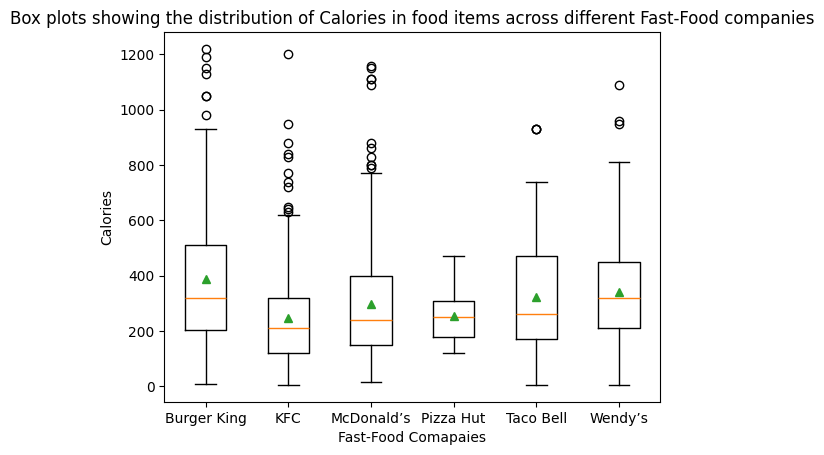

In [35]:
cal_info =  get_companies_dataseries("Calories")

plt.boxplot(cal_info, tick_labels=companies, showmeans=True)
plt.ylabel("Calories")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Calories in food items across different Fast-Food companies")
plt.show()


It's clear that Burger King has the highest median calories. Burger King also has a high range and IQR of Calories for their menu items which suggest they offer a wider veriety of high/low calorie food. Pizza hut has the smallest IQR which suggests it has food that a more calorie consistent. Companies other than Pizza Hut have outliers which implies they have a couple of menu items that are highly calorie dense. McDonald's, Taco Bell and Wendy's are very similar in the amount of calories in their food (similar IQR and similar Median)

Burger King has the highest mean calories and more possibility for higher calorie options. KFC has fewer high calorie options with much lower average calories. Similarly with Pizza Hut having medium average calories but having much fewer high calorie options.

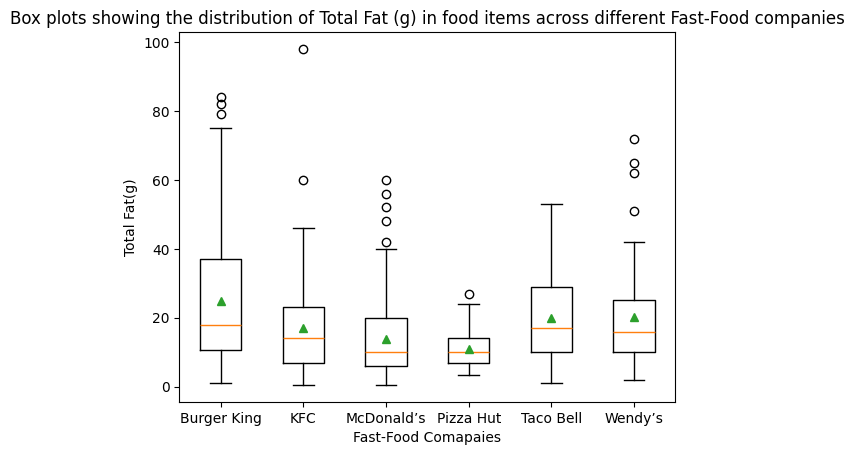

In [49]:
fat_info =  get_companies_dataseries("Total Fat(g)")

plt.boxplot(fat_info, tick_labels=companies, showmeans=True)
plt.ylabel("Total Fat(g)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Total Fat (g) in food items across different Fast-Food companies")
plt.show()


In [57]:
for i in range(len(companies)):
    print(str(fat_info[i].median()) +" ", end="")

18.0 14.0 10.0 10.0 17.0 16.0 

Burger King has the highest median total fat (18g) in their items with Taco Bell and Wendy's trailing very closely. McDonald's and Pizza Hut have the lowest medians total fat (10g). However, McDonald's mean is higher due to having more outliers so Pizza Hut can be taken to have the lowest total fat.
Burger King has the highest highest range of total fat in their food items also indicating a wide variety of menu options. Pizza Hut has again displayed the lowest range of total fat in their menu. 

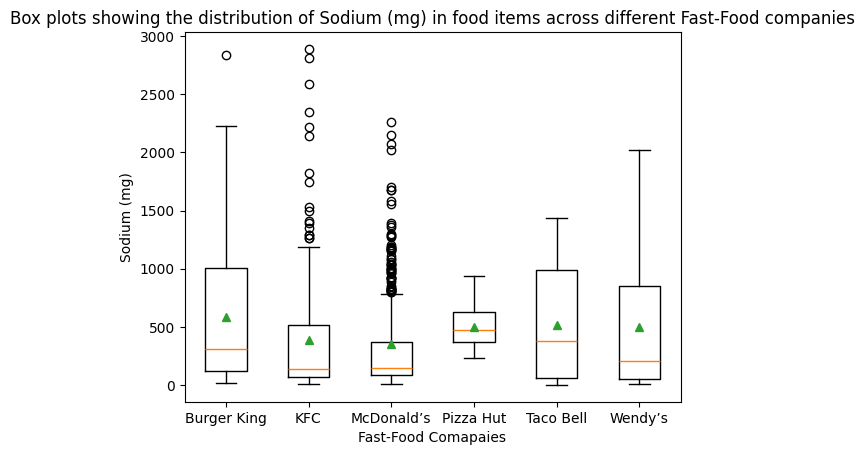

In [59]:
sod_info =  get_companies_dataseries("Sodium (mg)")

plt.boxplot(sod_info, tick_labels=companies, showmeans=True)
plt.ylabel("Sodium (mg)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Sodium (mg) in food items across different Fast-Food companies")
plt.show()


In [61]:
for i in range(len(companies)):
    print(str(sod_info[i].median()) +" ", end="")

310.0 140.0 150.0 475.0 380.0 210.0 

This time Pizza Hut has the highest median sodium on their menu (475mg). This is followed by Taco Bell (380mg) and Burger King (310mg) The rest (KFC, McDonald's, Wendy's) have much lower sodium in their menu. 
Burger King and Wendy's have the highest ranges and Pizza Hut and McDonald's have the lowest.
This time most of the data seems to be right-skewed indicated by the mean departing from the median, with McDonald's having significantly more outliers than any other.

<hr>
From this information only, it's clear that Burger is the most unhealthy in calories, total fat and sodium. It consistently came in the top 2 for each nutrient in terms of median and range. Pizza Hut was clearly the most consistent and KFC was arguably least unhealthy among the six options.

Pizza Hut's overall consistency may be explained due to its high proportion of pizzas, since most of a pizza remain the same with just the toppings varying

In [60]:
print(df[(df["Company"]== "Pizza Hut") & (df["Item"].str.contains("pizza", case=False))]["Item"].count()/df[df["Company"]== "Pizza Hut"]["Item"].count())

0.527027027027027


### Is the mean Calories from Fat of Burger King > the mean Calories from Fat of McDonald's

Since Burger King and McDonald's are close, we will test whether Burger King has significantly higher Calories from Fat at 5% significance level


H<sub>0</sub> : Burger King mean = McDonald's mean <br>
H<sub>1</sub> : Burger King mean > McDonald's mean <br>

In [20]:
BK_mean = company_dfs["Burger King"]["Calories from Fat"].dropna().mean()
BK_std =  company_dfs["Burger King"]["Calories from Fat"].dropna().std()
BK_n = len(company_dfs["Burger King"]["Calories from Fat"].dropna())

MD_mean = company_dfs["McDonald’s"]["Calories from Fat"].dropna().mean()
MD_std =  company_dfs["McDonald’s"]["Calories from Fat"].dropna().std()
MD_n = len(company_dfs["McDonald’s"]["Calories from Fat"].dropna())

dof = (MD_std**2/MD_n + BK_std**2/BK_n)**2/((MD_std**2/MD_n)**2/(MD_n - 1)+(BK_std**2/BK_n)**2/(BK_n - 1))
a = 0.05

In [21]:
BK_mean

np.float64(149.05027932960894)

In [22]:
dof

np.float64(243.25886426516445)

In [23]:
t = (BK_mean - MD_mean)/(np.sqrt((BK_std**2/BK_n) + (MD_std**2/MD_n)))
t

np.float64(4.228252230268862)

In [24]:
1-st.t.cdf(t, df = dof)

np.float64(1.6676808703097734e-05)

In [25]:
st.t.ppf(q=1-a, df = dof)

np.float64(1.6511416774670118)

In [26]:
st.ttest_ind(company_dfs["Burger King"]["Calories from Fat"].dropna(), company_dfs["McDonald’s"]["Calories from Fat"].dropna(),equal_var=False)

TtestResult(statistic=np.float64(4.228252230268862), pvalue=np.float64(3.3353617406197576e-05), df=np.float64(243.25886426516445))